In [1]:
# Get all the motiffs of a session and parse them in syllables that look nice
# Then to every syllable fit the parameters of the model using only f, sci

# Definitions and functions
%matplotlib inline
from __future__ import division
from imp import reload

import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob
from tqdm import tqdm


# my packages installed on passaro

from swissknife.bci.core import expstruct as et
from swissknife.h5tools import h5tools as h5
from swissknife.streamtools import streams as st
from swissknife.streamtools import spectral as sp
from swissknife.streamtools import temporal as tp


# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
sys.path.append(os.path.join(repos_folder, 'ephysflow'))

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp

from basic_viewing.structure import kwik_functions as kwkf
from basic_viewing.structure.core import h5_functions as kwdf
# done with this dirty importing


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

def list_sum(a_list):
    s = a_list.pop(-1)
    for new_s in a_list:
        s+=new_s
    return s

print 'All modules loaded'

Computer: passaro
All modules loaded


In [2]:
def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

def filter_rms(x, filter_pars):
    return st.rms(sp.apply_butter_bandpass(x, filter_pars))

def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []

    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                       s_f,
                                       dtype=np.float),
                             np.array(chan_list),
                             [start, start + span])
        frames.append(one_frame)
    return frames

import scipy


def spectrogram(x, s_f, n_perseg = None, n_overlap=None, cut_off=90, f_min=0., f_max=10000.):
    f, t, s = scipy.signal.spectrogram(x, fs=s_f, window=('gaussian', 80), 
                         nperseg=n_perseg, 
                         noverlap=n_overlap, 
                         nfft=None, 
                         detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')

    s[s<np.max(s)/np.exp(cut_off/10)]=np.max(s)/np.exp(cut_off/10)
    f_filter = np.where((f>f_min) & (f<f_max))
    return f[f_filter], t, s[f_filter]

def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u - u_min)/u_range

In [3]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
stim_sess = '001'
syn_sess = 2 # for the templates


spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

filter_band = [150, 7500]


    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
fn_syn = et.file_names(bird, '{:03d}'.format(syn_sess))

template_file_path = os.path.join(fn_syn['folders']['stim'], 'syl_templates_ms.p')
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = exp_par['search_motiff']['motiff_patterns']
print pattern_names

{'motiff_1': 'motiff_1.wav'}


550.4
fcut_plot 10000


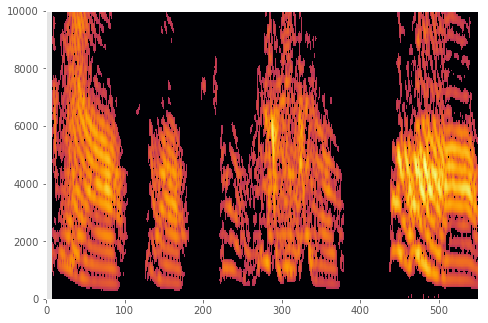

In [4]:
reload(sp)
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
ax = spec_obj.plot()

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide


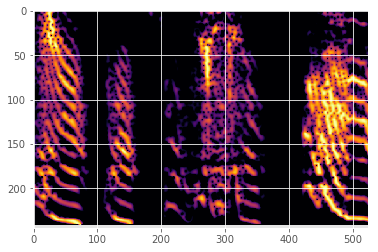

In [5]:
win_s = .001
win_samples = 128*8
step_s = .001
f_cut = 15000

#n_perseg = int(s_f * win_s)
n_perseg = win_samples

s_f = 30000
#n_overlap = int(s_f * (win_s - step_s))
n_overlap = win_samples - int(s_f*step_s)


f, t, s = spectrogram(m_chunk.data[:,0], s_f, n_perseg=n_perseg, 
                      n_overlap=n_overlap, cut_off=85,
                     f_min=300, f_max=7500)

plt.imshow(normalize(np.log(s))[::-1], aspect='auto', cmap='inferno')

(245, 525)


/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide


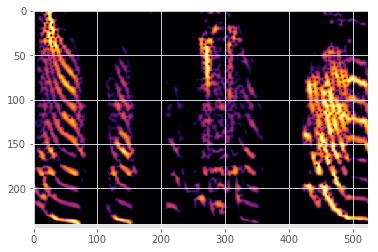

In [27]:
reload(sp)
f, t, s = sp.pretty_spectrogram(m_chunk.data[:,0], s_f, fft_size=n_perseg, log=True,
                      step_size=int(s_f*step_s), db_cut=65,
                     f_min=300, f_max=7500, window=('gaussian', 80))
print(s.shape)
plt.imshow(normalize((s))[::-1], aspect='auto', cmap='inferno')

2017-05-18 06:25:32,668 root         INFO     Collecting 71 frames...
2017-05-18 06:25:32,669 root         INFO     Frame 0 ...
2017-05-18 06:25:32,684 root         INFO     Frame 10 ...
2017-05-18 06:25:32,698 root         INFO     Frame 20 ...
2017-05-18 06:25:32,713 root         INFO     Frame 30 ...
2017-05-18 06:25:32,729 root         INFO     Frame 40 ...
2017-05-18 06:25:32,744 root         INFO     Frame 50 ...
2017-05-18 06:25:32,760 root         INFO     Frame 60 ...
2017-05-18 06:25:32,775 root         INFO     Frame 70 ...
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide


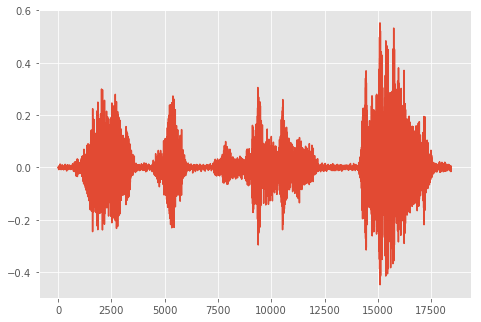

In [6]:
def make_data_frame(bird, sess, before=150, after=1000):
    
    exp_par = et.get_parameters(bird, sess)
    fn = et.file_names(bird, sess)
    song_file_path = et.file_path(fn, 'ss', 'sng')
    song_file = h5py.File(song_file_path, 'r')

    pattern_names = exp_par['search_motiff']['motiff_patterns']
    
    m = evt.Song(m_name, song_file)
    kwd_file = et.open_kwd(bird, sess)
    starts = m.get_start() - before
    recs = m.get_rec()

    m_starts = kwkf.apply_rec_offset(kwd_file, starts, recs)

    mic_chan = np.array([exp_par['channel_config']['mic']])

    win_samples = 192
    step_s = .001
    f_cut = 15000

    #n_perseg = int(s_f * win_s)
    n_perseg = win_samples
    
    n_overlap = win_samples - int(s_f*step_s)


    with et.open_kwd(bird, sess) as kwd_file:
        collected_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                                    s_f, 
                                    kwd_file, recs, mic_chan)

    spectra = []
    for one_frame in collected_frames:
        one_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)
        f, t, s = spectrogram(one_frame.data.flatten(), s_f, n_perseg=n_perseg, n_overlap=n_overlap, cut_off=75)
        spectra.append(normalize(np.log(s)))

    all_spectra = np.stack(spectra, axis=0)

    collected_frames[0].plot()

    syll_data = pd.DataFrame({
            'bird': [bird for i in np.ones_like(recs)],
            'sess': [sess for i in np.ones_like(recs)],
            'rec': recs.tolist(),
            'start': starts.tolist(),
            'spectral': all_spectra.tolist()
        })

    syll_data.to_pickle(os.path.join(fn['folders']['ss'], 'spectral_pandas.pickle'))
    return syll_data, f[f<f_cut], collected_frames

    
sessions = ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10',
           'day-2016-09-11', 'day-2016-09-12', 'day-2016-09-13', 'day-2016-09-14']

# sessions = ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19',
#            'day-2016-06-20', 'day-2016-06-21', 'day-2016-06-22', 'day-2016-06-23',
#            'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28']

# sessions = ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04',
#            'day-2016-06-05', 'day-2016-06-06']

#all_syl_data = [make_data_frame(bird, s)[0] for s in sessions]

all_syl_data, f, frames = make_data_frame(bird, sessions[2], before = 128, after=1536)

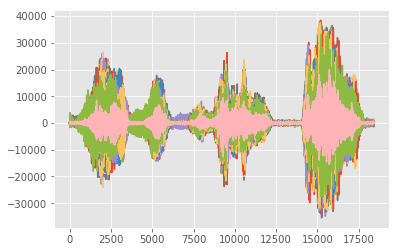

In [7]:
for i in range(70):
    plt.plot(frames[i].data)


/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide


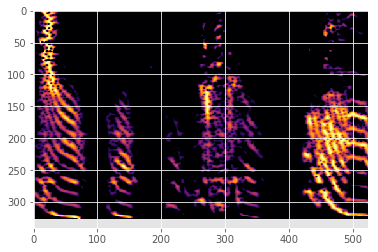

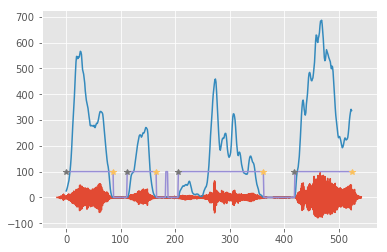

In [8]:
par = {'s_f': 30000,
      'n_perseg': win_samples,
      'n_overlap': n_overlap,
      'n_syl': 4,
      'min_syl_dur': 20,
      'cut_off': 75}

def parse_motiff(x, par):
    f, t, s = spectrogram(x, par['s_f'], 
                          n_perseg=par['n_perseg'], 
                          n_overlap=par['n_overlap'], 
                          cut_off=par['cut_off'])
    
    plt.imshow(normalize(np.log(s))[::-1], aspect='auto', cmap='inferno')
    n_syl = par['n_syl']
    min_syl_dur = par['min_syl_dur']
    s_f = par['s_f']
    
    win_samples = par['n_perseg']
    win_ms = int(win_samples/s_f*1000)
   
    # compute the intensity envelope
    intensity = np.sum(np.log(s), axis=0)
    intensity -= np.min(intensity)
    
    # get the below/above threshold
    silences = np.where(intensity==0)[0]
    no_silences = np.where(intensity>0)[0]
    onoff = np.ones_like(intensity, dtype=np.short)
    onoff[silences]=0
    
    # get segments of song/silence
    onsets = np.where(np.diff(onoff)==1)[0]
    offsets = np.where(np.diff(onoff)==-1)[0] 
    if onsets[0] > offsets[0]:
        onsets = np.concatenate([np.array([0]), onsets])
    if onsets[-1] > offsets[-1]:
        offsets = np.concatenate([offsets, np.array([intensity.size])])
    on_segments = np.vstack([onsets, offsets]).T
    
    # filter 'song' shorter that what a syllable should last
    np.where(np.diff(on_segments)>min_syl_dur)[0]
    on_segments = on_segments[np.where(np.diff(on_segments)>min_syl_dur)[0], :]
    
    intensity_linear = np.sum(s, axis=0)
    intensity_linear -= np.min(intensity_linear)
    intensity_linear /= np.max(intensity_linear)
    
    on_envelopes = [intensity_linear[s[0]: s[1]] for s in on_segments]

    #plot everyting
    plt.figure()
    plt.plot((np.arange(x.size) - n_perseg//2)/s_f * 1000 , x/300)
    plt.plot(intensity)
    plt.plot(onoff*100)
    #plt.plot(onsets, np.ones_like(onsets)*100, '*')
    #plt.plot(offsets, np.ones_like(offsets)*100, '*')
    plt.plot(on_segments, np.ones_like(on_segments)*100, '*')
    
    return on_segments + win_ms//2, on_envelopes

def check_parsed(all_parsed_motiffs, n_syl):
    # make sure they have right number of syllables
    well_parsed_list = [[i, x] for i, x in enumerate(all_parsed_motiffs) if x.shape[0]==n_syl]
    well_parsed_idx = []
    well_parsed_list = []
    for i, x in enumerate(all_parsed_motiffs):
        if x.shape[0] == n_syl:
            well_parsed_idx.append(i)
            well_parsed_list.append(x)

    well_parsed_mot = np.stack(well_parsed_list)
    return well_parsed_idx, well_parsed_mot
    
o_s, o_envs = parse_motiff(m_chunk.data[:, 0], par)

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


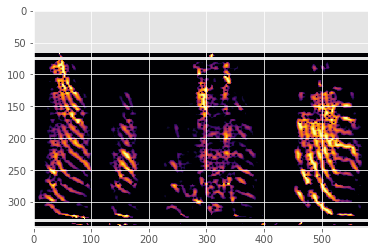

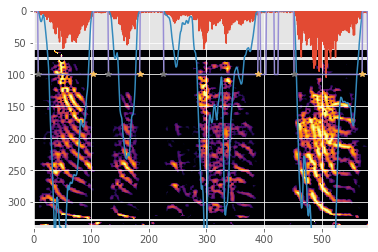

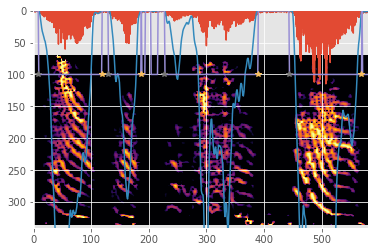

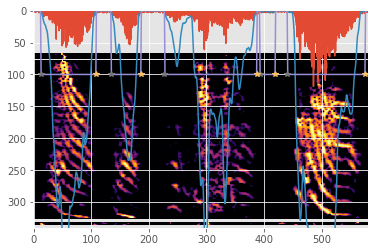

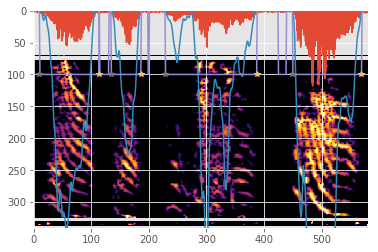

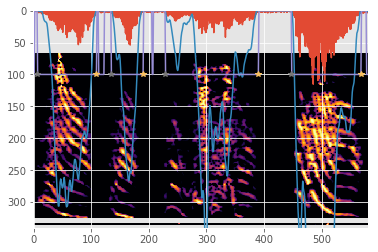

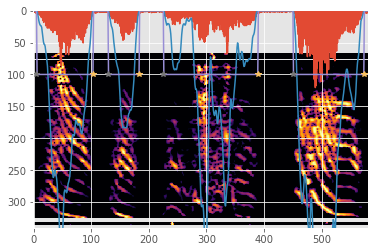

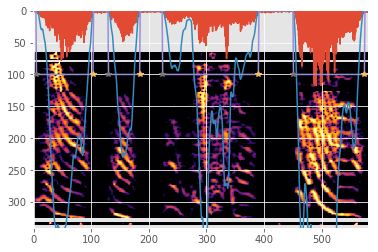

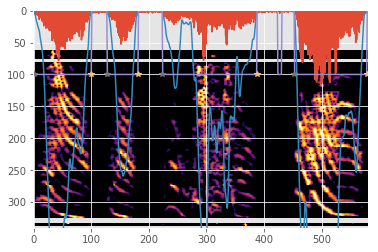

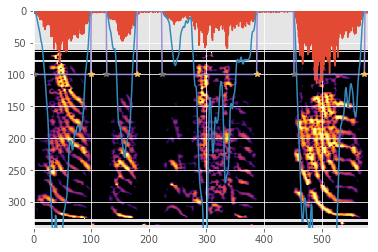

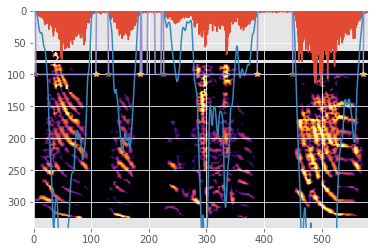

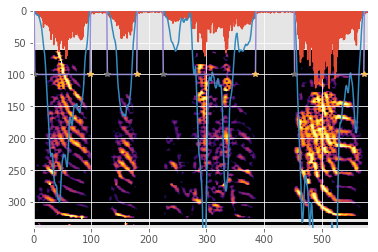

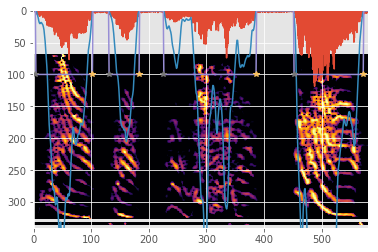

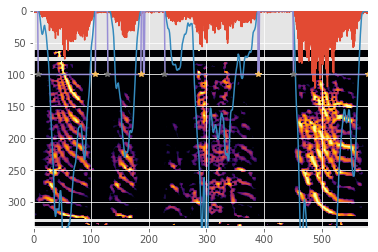

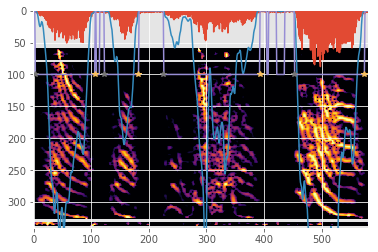

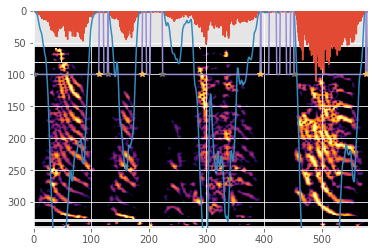

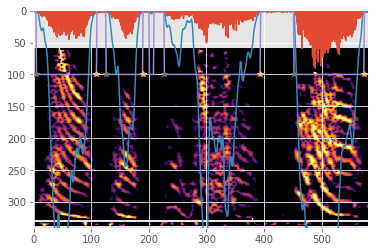

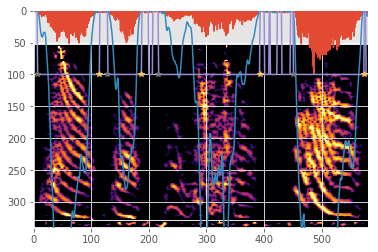

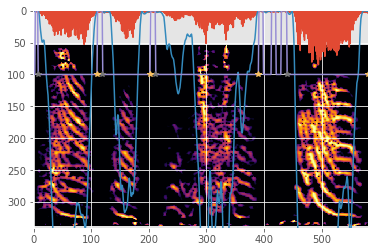

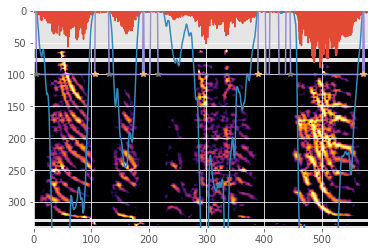

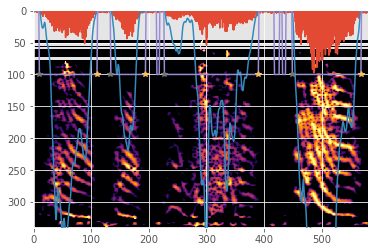

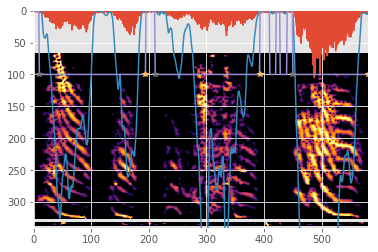

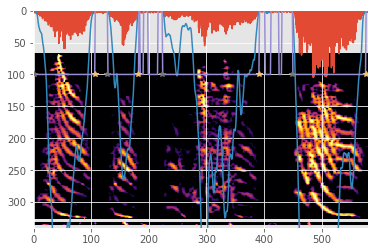

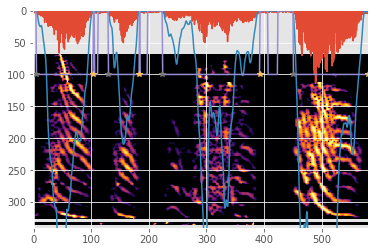

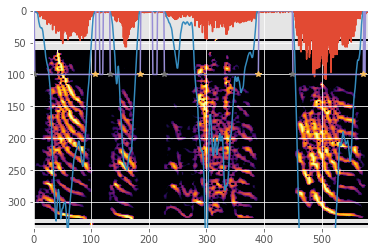

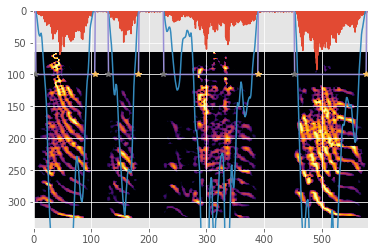

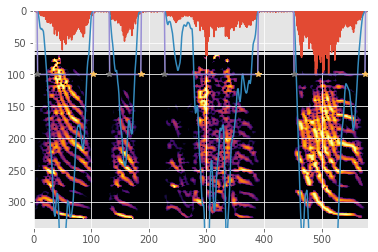

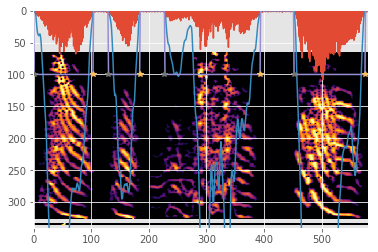

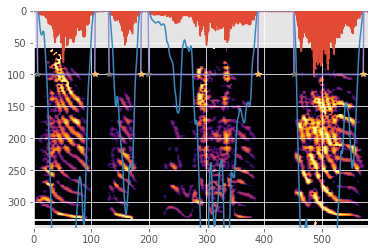

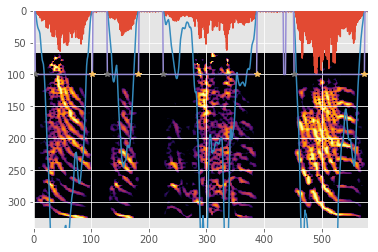

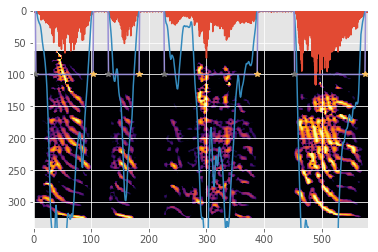

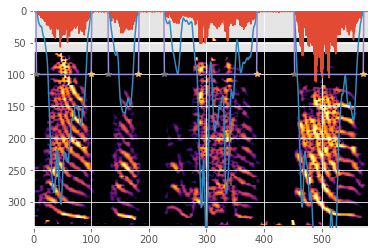

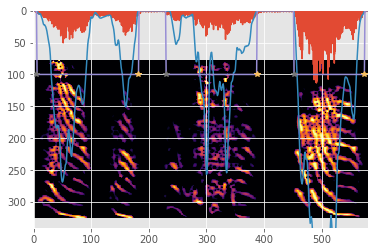

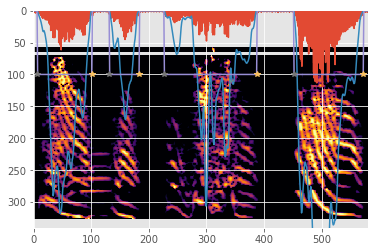

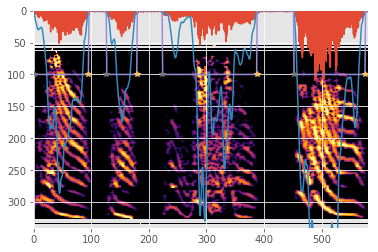

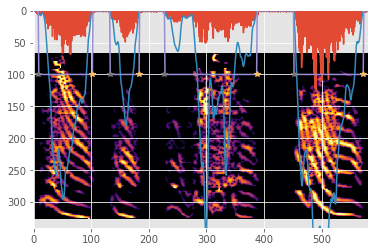

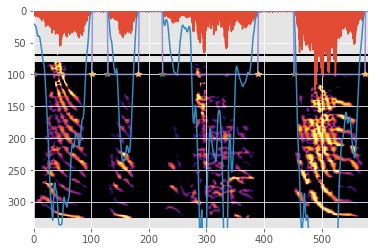

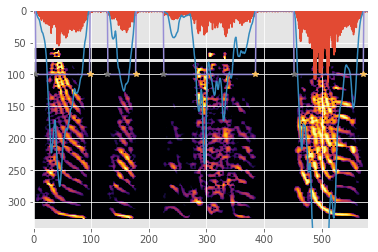

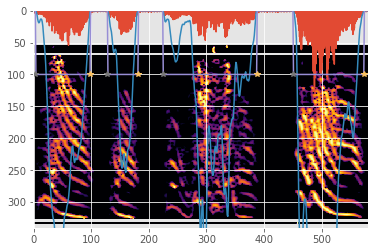

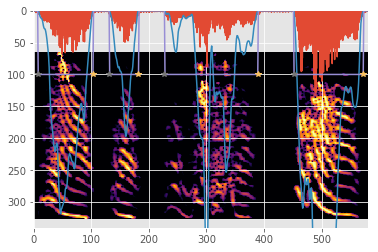

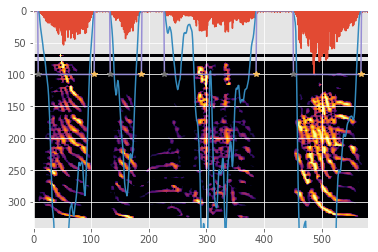

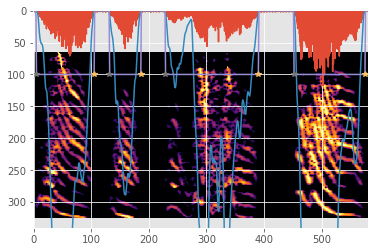

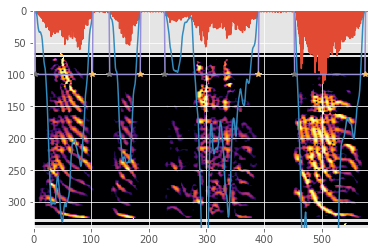

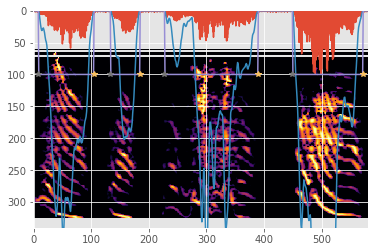

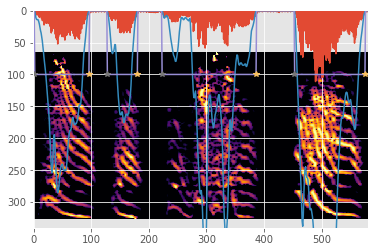

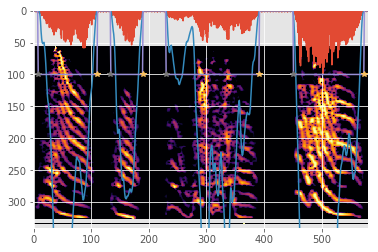

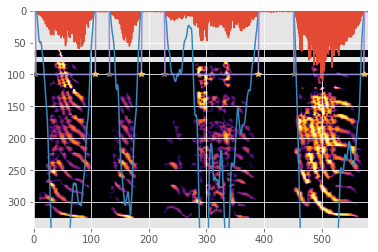

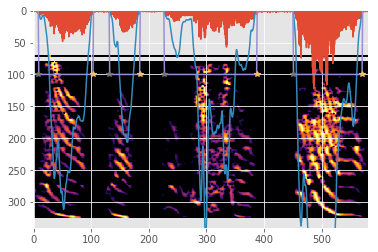

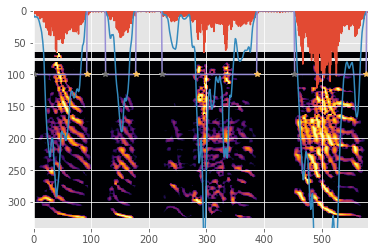

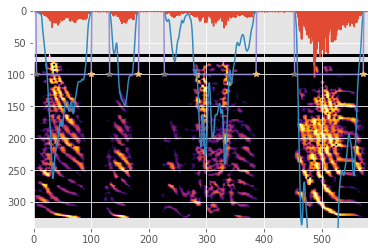

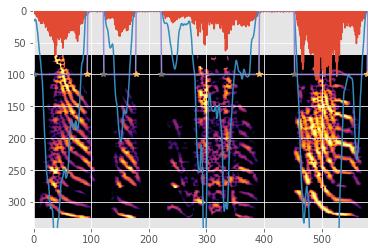

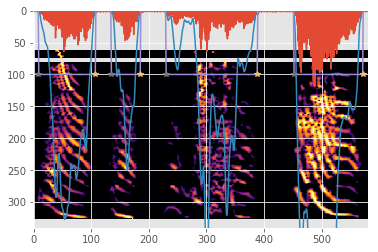

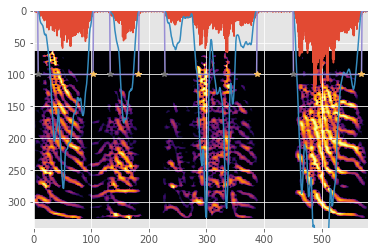

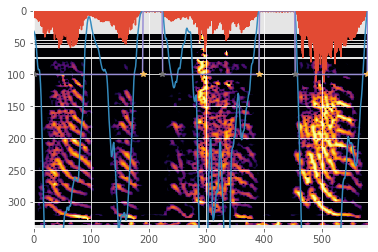

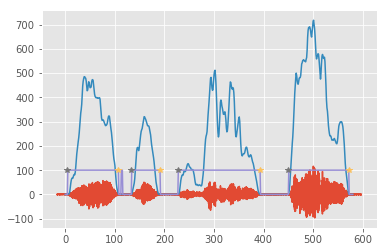

In [9]:
all_parsed = map(lambda x: parse_motiff(x.data.flatten(), par), frames)
all_parsed_motiffs = [p[0] for p in all_parsed]
all_parsed_envelopes = [p[1] for p in all_parsed]

In [17]:
plt.plot(all_parsed_envelopes[0][3])

In [18]:
int(win_samples/s_f*1000)//2

17

In [19]:
well_parsed_idx, well_parsed_mot = check_parsed(all_parsed_motiffs, 4)
well_parsed_env = [all_parsed_envelopes[i] for i in well_parsed_idx]

In [20]:
well_parsed_mot.shape

(65, 4, 2)

In [21]:
def arrange_syl(well_parsed_idx, well_parsed_mot, well_parsed_env, all_syl_data):
    #make a pandas dataframe with all the syllables
    n_mot, n_syl, _ = well_parsed_mot.shape
    all_syl_pd = []
    for i_syl in np.arange(n_syl):
        syl_pd = pd.DataFrame({
            'bird': [bird for i in well_parsed_idx],
            'sess': [sess for i in well_parsed_idx],
            'rec': np.array(all_syl_data['rec'].tolist())[well_parsed_idx],
            'mot_start': np.array(all_syl_data['start'].tolist())[well_parsed_idx],
            'mot_id': well_parsed_idx,
            'syl_type': np.ones_like(well_parsed_idx)*i_syl,
            'start': well_parsed_mot[:, i_syl, 0],
            'end': well_parsed_mot[:, i_syl, 1],
            'keep': [False for i in well_parsed_idx],
            'env': [env[i_syl] for env in well_parsed_env]
        })
        all_syl_pd.append(syl_pd)
    return pd.concat(all_syl_pd)

def filter_syllables(syl_df, tightness=.075):
    syl_df['duration'] = syl_df['end'] - syl_df['start']
    syl_types = np.unique(syl_df['syl_type'])
    filtered_syl = []
    for s_t in syl_types:
        #print(syl_types['syl_type'])
        s_t_df = syl_df[syl_df['syl_type'] == s_t]
        duration = s_t_df['duration']
        keeper = np.abs(duration - duration.mean())/duration.median() < tightness
        s_t_df.loc[:, 'keep'] = keeper.tolist()
        filtered_syl.append(s_t_df)
    return pd.concat(filtered_syl)

arsyl = arrange_syl(well_parsed_idx, well_parsed_mot, well_parsed_env, all_syl_data)
filt_syl = filter_syllables(arsyl, tightness=0.075)

#filt_syl.to_pickle(os.path.join(fn['folders']['ss'], 'syllable_pandas.pickle'))


/usr/local/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
# collect the actual stream for every syllable
syl_streams = []
for syl_start, syl_end, mot_id in zip(filt_syl['start'], filt_syl['end'], filt_syl['mot_id']):
    syl_streams.append(frames[mot_id].data.flatten()[syl_start*s_f//1000:syl_end*s_f//1000 + 512])
filt_syl['rw_stream'] = syl_streams


In [27]:
import pickle
# get the templates and add the alpha, beta for each syllable
with open(template_file_path, 'rb') as pf:
    fit_template = pickle.load(pf)

starts = np.array(filt_syl['start'].tolist())
ends = np.array(filt_syl['end'].tolist())
types = np.array(filt_syl['syl_type'].tolist())

alphas = []
betas = []
for ty, st, en in zip(types, starts, ends):
    dur = en - st
    alphas.append(-0.15*np.ones([dur, ]))
    betas.append(sg.resample(fit_template['beta'][ty], dur))
    
filt_syl['alpha'] = alphas
filt_syl['beta'] = betas

# save the syllable data
filt_syl.to_pickle(os.path.join(fn['folders']['ss'], 
                               'syllable_pandas_template_{}.pickle'.format(0)))

In [24]:
# get the silences
mot_id = 0

def make_silence_pd(mot_id, filt_syl, silence_par_values=[0, 0, 0]):
    #silence_par_values = [0, 0, 0] # for alpha, beta, env
    mot_pd = filt_syl[filt_syl['mot_id']==mot_id]
    ends = np.array([0] + mot_pd.end.tolist())
    starts = np.array(mot_pd.start.tolist() + [ends[-1] + 20])
    durations = starts - ends

    silence_pd = pd.DataFrame({
            'bird' : [mot_pd['bird'].tolist()[0] for i in range(starts.size)],
            'mot_id' : [mot_pd['mot_id'].tolist()[0] for i in range(starts.size)],
            'mot_start' : [mot_pd['mot_start'].tolist()[0] for i in range(starts.size)],
            'sess' : [mot_pd['sess'].tolist()[0] for i in range(starts.size)],
            'rec' : [mot_pd['rec'].tolist()[0] for i in range(starts.size)],
            'keep' : [mot_pd['keep'].tolist()[0] for i in range(starts.size)],
            'rw_stream': [np.nan for i in range(starts.size)],
            'syl_type': [-1 for i in range(starts.size)],
            'duration': durations,
            'start': ends,
            'end': starts
        })


    off_templates = [np.ones([d, 3])*silence_par_values for d in durations]

    for i_p, new_field in enumerate(['alpha', 'beta', 'env']):
        par_var_list = [par[:, i_p] for par in off_templates]
        aux_series = pd.DataFrame({new_field: par_var_list})
        silence_pd[new_field] = aux_series
    return silence_pd

one_silence_pd = make_silence_pd(1, filt_syl)

all_silence_pd = pd.concat([make_silence_pd(m_id, filt_syl) for m_id in np.unique(filt_syl.mot_id.as_matrix())])

all_silence_pd.to_pickle(os.path.join(fn['folders']['ss'], 
                               'syllable_pandas_template_{}.pickle'.format(-1)))